In [1]:
import numpy as np
import math

from braket.circuits import Circuit
from braket.circuits import circuit 

from braket.aws import AwsDevice
from braket.aws import AwsQuantumTask

from braket.devices import LocalSimulator

import matplotlib.pyplot as plt

plt.style.use("dark_background")

# Simple Example: 3 qubits

## Useful functions!

In [2]:
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """
    implementation of three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]],
                       dtype=complex)
    
    # instantiate circuit object
    circ = Circuit()
    
    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)
    
    return circ

## The Oracle

Let us say that we have a domain of {0,1,...,7}, which can be seen as {000,001,...,111}. For the purposes of this exercise, let's say we want a function that finds the element 100. How would you implement such an oracle?

Remember, what this oracle does is change the phase of 100, while keeping the rest the same. Hint: use CCZ!

Input: Doesn't need an input

Output: Quantum Circuit

In [3]:
def build_100_oracle():
    
    circ = Circuit()
    
    circ.x(1)
    circ.x(2)
    circ.ccz(targets=[0, 1, 2])
    circ.x(1)
    circ.x(2)            
            
    return circ

## The Diffusion Operator

To construct the entire Grover Diffusion Operator, we first need a circuit subroutine that changes the phase of 000. Implement it here first! 

In [4]:
def build_000_phase_change():
    
    circ = Circuit()
    
    circ.x(0)
    circ.x(1)
    circ.x(2)
    circ.ccz(targets=[0, 1, 2])
    circ.x(0)
    circ.x(1)
    circ.x(2)            
            
    return circ

With that, we can create the diffusion operator!

In [5]:
def diffusion_operator_3qubits():
    
    circ = Circuit()
    
    circ.h(np.arange(3))
    circ.add_circuit(build_000_phase_change())
    circ.h(np.arange(3))
    
    return circ
    

## The Grover Circuit

With the oracle and the grover diffusion operator, we can implement Grover's algorithm! Here, write the code for Grover's algorithm to find 100.

In [6]:
def build_grover_circuit_100(n_qubits=3, iterations_count=1):
    
    # Initial State
    
    circ = Circuit()
    circ.h(np.arange(n_qubits))
    
    # Oracle
    
    oracle_circuit = build_100_oracle()
    
    # Amplification
    
    amplification_circuit = diffusion_operator_3qubits()
    
    # Iterations
    
    for iteration in range(iterations_count):
        
        circ.add(oracle_circuit)        
        circ.add(amplification_circuit)
        
    # Measurement
    
    circ.probability()
    
    return circ

## Running the Algorithm

In [7]:
# Local Device

DEVICE = LocalSimulator()
SHOTS_COUNT = 1000


In [8]:
grover_circuit = build_grover_circuit_100(iterations_count=2)

In [9]:
print(grover_circuit)

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|Result Types|
                                                            
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--Probability--
          |       |       |           |        |            
q1 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--Probability--
          |       |       |           |        |            
q2 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--Probability--

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|Result Types|


In [10]:
task = DEVICE.run(grover_circuit, shots=SHOTS_COUNT)

In [11]:
result = task.result()

In [12]:
probabilities = result.values[0]

probabilities

array([0.005, 0.009, 0.012, 0.009, 0.94 , 0.008, 0.007, 0.01 ])

In [13]:
qubits_count = grover_circuit.qubit_count

states_count = 2 ** qubits_count

state_pattern = f"0{qubits_count}b"

states = [f"{state:{state_pattern}}" for state in range(states_count)]

states

['000', '001', '010', '011', '100', '101', '110', '111']

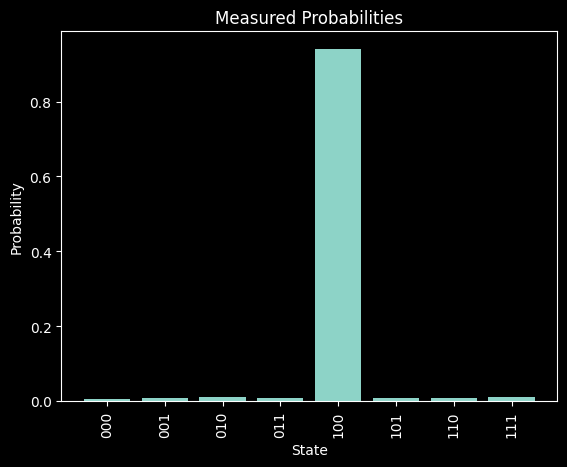

In [14]:
plt.bar(states, probabilities)

plt.title("Measured Probabilities")
plt.xlabel("State")
plt.ylabel("Probability")

plt.xticks(rotation=90)

# plt.savefig('grover.png', dpi=100)

plt.show()

# Generalizing Simple Case

Now that we have seen Grover's Algorithm in action, let's try to generalize it! We now want to make it work for any state, supposing we know the state beforehand.

## The Oracle

We now have a domain of that we have a domain of {0,1,...,2^n - 1}, which can converted into binary form. For the purposes of this exercise, let's say we know that we want to find an arbitrary state that is of length n. How would you implement such an oracle?

Input: String, representing the state. For example, "10010" or "0001011"

Output: Quantum Circuit

You will first need to change the useful function!

In [15]:
@circuit.subroutine(register=True)
def cnz(targets):
    
    qubits_count = len(targets)
    
    # CnZ Unitary

    identity = np.eye(2)
    unitary = identity

    for qubit in range(qubits_count - 1):
        unitary = np.kron(unitary, identity)

    unitary[-1, -1] = -unitary[-1, -1]
    
    # CCZ Circuit

    circ = Circuit()
    circ.unitary(matrix=unitary, targets=targets)
    
    return circ

Then you can implement the oracle

In [16]:
def build_phase_oracle(state):
    
    qubits = list(range(len(state)))
    
    circuit = Circuit()
    
    for index, bit in enumerate(state):
        if bit == "0":
            circuit.x(index)

    circuit.cnz(targets=qubits)
    
    for index, bit in enumerate(state):
        if bit == "0":
            circuit.x(index)
            
    return circuit

## The Diffusion Operator

To construct the entire Grover Diffusion Operator, we first need a circuit subroutine. What is it? Does it resemble any other function? Implement it here first! 

In [17]:
def build_phase_change(state):
    
    qubits_count = len(state)
    
    circ = Circuit()
    
    zero_oracle = build_phase_oracle('0' * qubits_count)    
    circ.add_circuit(zero_oracle)
            
    return circ

Then we can construct the diffusion operator!

In [18]:
def diffusion_operator(state):
    
    qubits_count = len(state)
    
    circ = Circuit()
    
    circ.h(np.arange(qubits_count))
    circ.add_circuit(build_phase_change(state))
    circ.h(np.arange(qubits_count))
    
    return circ

## The Grover Circuit

With all the tools above, this will be the Grover Circuit:

In [19]:
def build_grover_circuit(state, iterations_count=1):
    
    qubits_count = len(state)
    qubits = list(range(qubits_count))
    
    # Initial State
    
    circ = Circuit()
    circ.h(qubits)
    
    # Oracle
    
    oracle_circuit = build_phase_oracle(state)
    
    # Amplification
    
    amplification_circuit = diffusion_operator(state)
    
    # Iterations
    
    for iteration in range(iterations_count):
        
        circ.add(oracle_circuit)        
        circ.add(amplification_circuit)
        
    # Measurement
    
    circ.probability()
    
    return circ

## Running the Algorithm

In [20]:
# Local Device

DEVICE = LocalSimulator()
SHOTS_COUNT = 1000

state = "10101"

n_iterations = int(np.round((np.pi/4) * np.sqrt((2 ** len(state)))))

In [21]:
grover_circuit = build_grover_circuit(state, iterations_count=n_iterations)

In [22]:
print(grover_circuit)

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|Result Types|
                                                                                                            
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H-----U--H--X-----U--X--H--Probability--
          |       |       |           |           |           |           |           |        |            
q1 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--Probability--
          |       |       |           |           |           |           |           |        |            
q2 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H-----U--H--X-----U--X--H--Probability--
          |       |       |           |           |           |           |           |        |            
q3 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--Probability--
          |       |

In [23]:
task = DEVICE.run(grover_circuit, shots=SHOTS_COUNT)
result = task.result()

In [24]:
probabilities = result.values[0]

probabilities

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.999, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

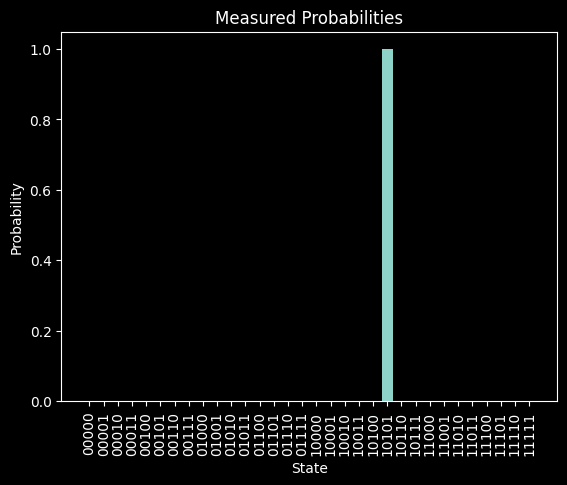

In [25]:
qubits_count = grover_circuit.qubit_count

states_count = 2 ** qubits_count

state_pattern = f"0{qubits_count}b"

states = [f"{state:{state_pattern}}" for state in range(states_count)]

plt.bar(states, probabilities)

plt.title("Measured Probabilities")
plt.xlabel("State")
plt.ylabel("Probability")

plt.xticks(rotation=90)

# plt.savefig('grover.png', dpi=100)

plt.show()